## Importing Libraries and Loading Data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Load the dataset
df = pd.read_csv("/content/groceries.csv")

# Display the first few rows of the dataset
df.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9835, 33)

## Data Cleaning
### Check for Missing Values
Untuk mengidentifikasi transaksi dengan nilai yang hilang atau tidak sesuai dalam jumlah item, kami membandingkan jumlah nilai yang tidak hilang dalam setiap transaksi untuk kolom 'Item 1' hingga 'Item 32' dengan jumlah item yang ditentukan dalam kolom 'Item(s)'. Jika angka-angka tersebut tidak sesuai, itu menunjukkan bahwa beberapa item hilang dalam transaksi tersebut.

In [3]:
# Calculate the number of non-missing values in each transaction
num_non_missing_per_transaction = df.iloc[:, 1:33].count(axis=1)

# Extract the column containing the number of items in each transaction
num_items_per_transaction = df["Item(s)"]

# Check if the number of non-missing values in each transaction is the same as the number of items
is_complete_transaction = (num_non_missing_per_transaction == num_items_per_transaction)

# Count the number of rows where the number of items is not the same as the number of items in 'Item(s)' column
num_rows_with_missing_values = (~is_complete_transaction).sum()

# Print the number of rows with missing values or mismatches between the number of items and non-missing values
print("Number of Rows with Missing Values (Mismatch in Number of Items):", num_rows_with_missing_values)

Number of Rows with Missing Values (Mismatch in Number of Items): 0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dari hasil di atas, kami perhatikan bahwa tidak ada nilai yang hilang dalam kumpulan data ini. Semua transaksi memiliki informasi lengkap, memungkinkan kami melanjutkan analisis tanpa adanya kesenjangan data atau entri yang hilang

### Handling Outliers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


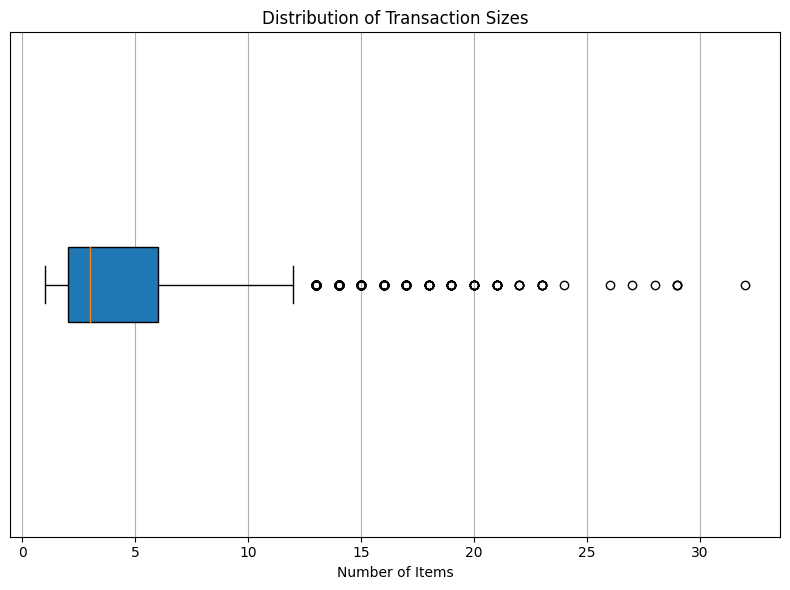

In [4]:
# Create a box plot to visualize the distribution of transaction sizes and identify outliers
plt.figure(figsize=(8, 6))

# Use patch_artist=True to fill the box plot with colors
plt.boxplot(num_items_per_transaction, vert=False, patch_artist=True)

# Customize the plot for better presentation
plt.title("Distribution of Transaction Sizes")
plt.xlabel("Number of Items")
plt.grid(axis="x")  # Show grid lines on the x-axis for better readability
plt.yticks([])  # Remove the labels for the y-axis

plt.tight_layout()

# Show the plot
plt.show()

Dalam kasus ini, pencilan, seperti transaksi dengan jumlah item yang signifikan (misalnya, 32 item), sering kali dapat diatributkan kepada variasi alami dalam perilaku pelanggan. Kejadian-kejadian ini mungkin muncul selama acara khusus, pembelian massal, atau saat menyediakan ke segmen pelanggan tertentu dengan pola pembelian yang unik. Dengan mempertahankan pencilan ini, kita dapat memperoleh pemahaman yang lebih komprehensif tentang kumpulan data, menangkap beragam preferensi dan perilaku pelanggan.

## Item Frequency Analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


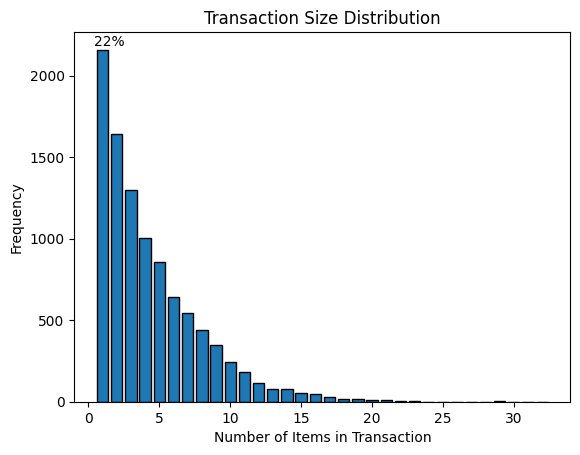

In [5]:
# Calculate the maximum and minimum transaction sizes
min_size = min(num_items_per_transaction)
max_size = max(num_items_per_transaction)

# Create bins with a size of 1
bins = list(range(min_size, max_size + 2))

# Create histograms for transaction sizes
plt.hist(num_items_per_transaction, bins=bins, edgecolor="black", align="left", rwidth=0.8)
plt.title("Transaction Size Distribution")
plt.xlabel("Number of Items in Transaction")
plt.ylabel("Frequency")

# Calculate the percentage of each number of item in the "Item(s)" column
item_count = df["Item(s)"].value_counts()
total_transactions = len(df["Item(s)"])
percentage_item_purchases = (item_count / total_transactions) * 100

# Get the height (frequency) of the first bar
height_first_bar = plt.gca().patches[0].get_height()

# Set the label for the first bar with the percentage value
plt.annotate(f"{round(percentage_item_purchases[1])}%",
             xy=(bins[0] + 0.5, height_first_bar),
             xytext=(0, 3),
             textcoords="offset points",
             ha='center',
             fontsize=10)

plt.show()

Distribusi ukuran transaksi tampak condong ke kanan, dengan sebagian besar transaksi terdiri dari hanya satu barang. Yang menarik, pembelian satu barang menyumbang sekitar 22% dari semua transaksi, menunjukkan bahwa banyak pelanggan lebih suka pembelian spesifik dan individual daripada membeli banyak barang bersamaan.

Kemunculan transaksi satu barang menunjukkan berbagai aspek perilaku dan preferensi pelanggan. Pertama, hal ini menyoroti popularitas produk tertentu yang pelanggan sering membelinya sendiri. Memahami alasan di balik pembelian mandiri ini dapat membantu kita menyesuaikan strategi pemasaran untuk menarik pelanggan ini dan lebih mempromosikan produk spesifik tersebut.

Distribusi ukuran transaksi yang condong ke kanan, di mana sebagian besar transaksi terdiri dari hanya satu barang, juga sangat mengindikasikan kemungkinan perilaku pembelian impulsif di antara pelanggan kita. Banyak transaksi mungkin didorong oleh keputusan spontan, di mana pelanggan mengambil barang secara mendadak tanpa berniat untuk membuat pembelian yang lebih besar. Wawasan ini dapat membimbing kita dalam merancang tampilan promosi atau rekomendasi online di dekat kasir untuk mendorong pembelian tambahan dan memanfaatkan kecenderungan pembelian impulsif tersebut.

Selain itu, grafik ini menimbulkan kemungkinan adanya produk spesialis atau niche yang pelanggan beli secara terpisah dari belanja bahan makanan reguler mereka. Mengidentifikasi barang unik ini dapat memberikan kesempatan untuk melayani segmen pelanggan tertentu yang tertarik dengan produk tersebut, yang berpotensi mengarah ke kampanye pemasaran yang ditargetkan dan peningkatan kepuasan pelanggan.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


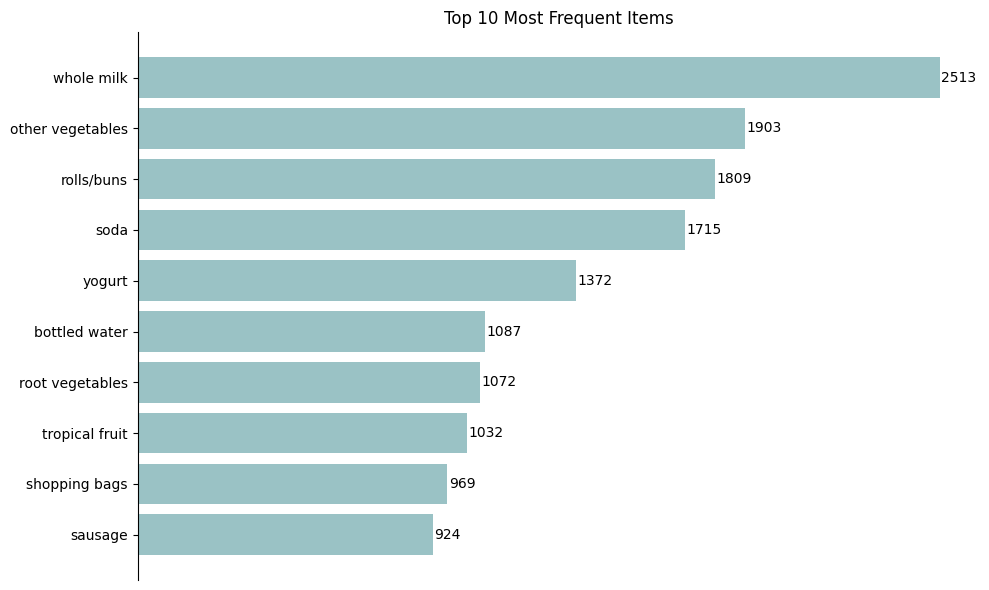

In [6]:
# Calculate the frequency of each item in the DataFrame by stacking the columns and counting occurrences
item_counts = df.iloc[:, 1:].stack().value_counts()

# Sort items by frequency in descending order
sorted_items_desc = item_counts.sort_values(ascending=False)

# Select the top 10 most frequent items
top_10_items = sorted_items_desc.head(10)

# Create a horizontal bar plot for the top 10 most frequent items
plt.figure(figsize=(10, 6))

# Set the color for the bars
bar_color = "#9AC2C5"

# Plot the horizontal bar chart
bars = plt.barh(range(len(top_10_items)), top_10_items.values, color=bar_color)

# Set y-ticks and labels
plt.yticks(range(len(top_10_items)), top_10_items.index)

# Invert the y-axis
plt.gca().invert_yaxis()

# Remove right, top, and bottom borders
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)

# Remove x-axis ticks and labels
plt.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# Add values beside the bars
for index, value in enumerate(top_10_items.values):
    plt.text(value + 5, index, str(value), ha="left", va="center")

# Remove grid
plt.grid(False)

# Remove y-axis label and x-axis title
plt.ylabel("")
plt.xlabel("")

# Set title
plt.title("Top 10 Most Frequent Items")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Dari grafik yang menampilkan “Top 10 Most Frequent Items”, kita dapat mengamati pola pembelian pelanggan terkait barang-barang bahan makanan. Grafik batang horizontal menggambarkan sepuluh produk yang paling sering terjual, diurutkan berdasarkan frekuensi penjualan dari tinggi ke rendah.

Di bagian atas grafik, whole milk menonjol sebagai barang yang paling banyak terjual, mencerminkan popularitasnya yang signifikan di antara basis pelanggan kita. Setelah whole milk, kita melihat barang-barang lain yang sering dibeli, seperti other vegetables, rolls/burns, dan soda, menunjukkan permintaan yang konsisten untuk bahan makanan pokok ini.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


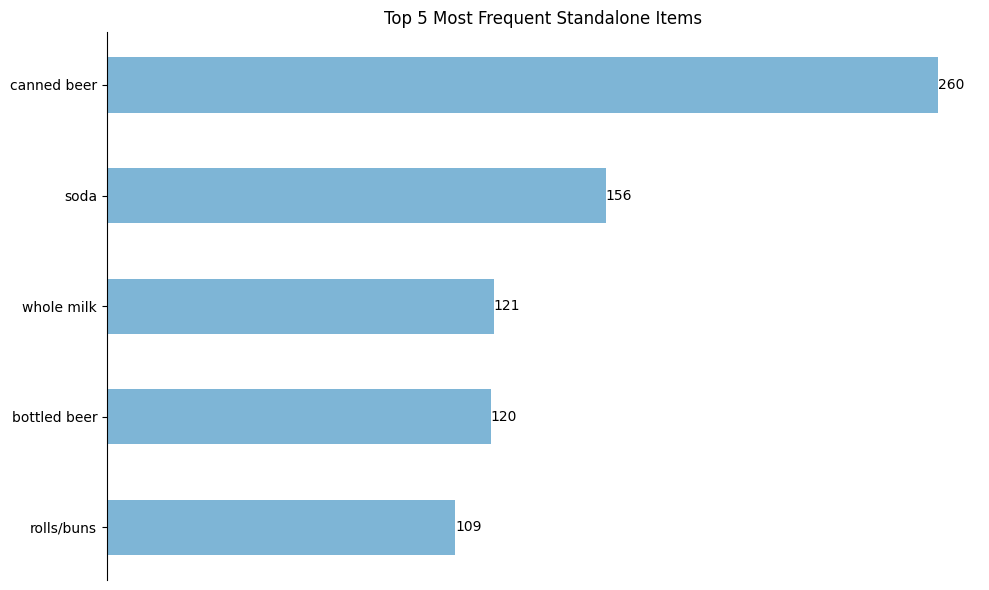

In [7]:
# Extract the item columns
item_columns = df.columns[1:33]

# Create a new DataFrame to store the standalone purchases (transactions with only one item)
standalone_purchases = df[df["Item(s)"] == 1][item_columns]

# Item Frequency Analysis for Standalone Purchases
standalone_item_counts = standalone_purchases.stack().value_counts()
top_standalone_items = standalone_item_counts.head(5)  # Get the top 5 most frequent standalone items

# Create a horizontal bar plot for the top 5 most frequent standalone items
plt.figure(figsize=(10, 6))  # Set the figure size

# Set the color for the bars
bar_color = "#7EB5D6"

# Plot the horizontal bar chart with the specified color
plt.barh(top_standalone_items.index, top_standalone_items.values, color=bar_color, height=0.5)

# Remove y-axis label and x-axis title
plt.ylabel("")
plt.xlabel("")

plt.title("Top 5 Most Frequent Standalone Items")

# Add frequency values above each bar
for index, value in enumerate(top_standalone_items.values):
    plt.text(value, index, str(value), ha="left", va="center", color="black")

# Invert the y-axis to display items with the highest frequency on top
plt.gca().invert_yaxis()

# Remove x-axis ticks and labels
plt.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# Remove grid
plt.grid(False)

# Remove right and top spines for cleaner aesthetics
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)

plt.tight_layout()

# Display the plot
plt.show()

Lima barang paling sering dibeli secara mandiri adalah canned beer, soda, whole milk, bottled beer, dan rolls/buns. Barang-barang ini tampaknya cocok dengan pelanggan sebagai pembelian mandiri, menunjukkan popularitas dan permintaan mereka.

Wawasan ini memberikan informasi berharga untuk menyesuaikan strategi pemasaran dan meningkatkan pengalaman pelanggan:


*   Karena canned beer, soda, dan bottled beer adalah barang paling sering dibeli secara mandiri, pertimbangkan untuk mempromosikannya saat waktu belanja puncak atau kesempatan khusus untuk meningkatkan penjualan lebih lanjut.
*   Untuk whole milk dan rolls/buns, jelajahi peluang penjualan silang dengan merekomendasikan produk yang melengkapi yang cocok dengan barang-barang ini, seperti sereal untuk susu atau selai untuk rolls/buns.
*   Untuk mendorong pelanggan untuk menjelajahi barang tambahan, pertimbangkan untuk menawarkan paket bundle yang mencakup beberapa barang paling sering dibeli secara mandiri bersama dengan produk terkait.

## Apriori Algorithm

In [8]:
# Extract the item columns
item_columns = df.columns[1:33]

# Convert the data into a list of transactions
transactions = df[item_columns].apply(lambda row: row.dropna().tolist(), axis=1).tolist()

# Create a one-hot encoded DataFrame for the transactions
onehot_transactions = pd.DataFrame(transactions)

# Apply one-hot encoding
onehot_encoded = pd.get_dummies(onehot_transactions.unstack()).groupby(level=1).max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py

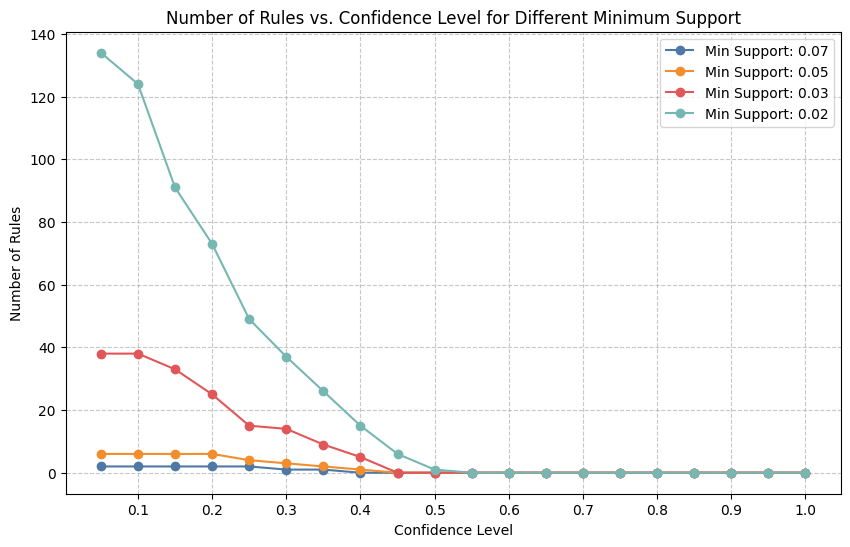

In [9]:
# List of minimum support values
min_support_values = [0.07, 0.05, 0.03, 0.02]

# Confidence levels to evaluate
confidence_levels = list(np.arange(0.05, 1.05, 0.05))

# Empty lists to store results
num_rules_lists = []

# Calculate and store the number of rules for each combination of minimum support and confidence level
for min_support in min_support_values:
    frequent_itemsets = apriori(onehot_encoded, min_support=min_support, use_colnames=True)
    rules_list = []
    for confidence_level in confidence_levels:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence_level)
        num_rules = len(rules)
        rules_list.append(num_rules)
    num_rules_lists.append(rules_list)

# Plot the results
plt.figure(figsize=(10, 6))

colors = ["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]

for i, min_support in enumerate(min_support_values):
    plt.plot(confidence_levels, num_rules_lists[i], marker="o", color=colors[i], label=f"Min Support: {min_support}")

plt.xlabel("Confidence Level")
plt.ylabel("Number of Rules")
plt.title("Number of Rules vs. Confidence Level for Different Minimum Support")

# Set the desired x-axis labels
plt.xticks([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1])

# Add grid lines for better readability
plt.grid(True, linestyle="--", alpha=0.7)

plt.legend()
plt.show()

Pada grafik di atas, kita dapat melihat jumlah aturan yang dihasilkan dengan berbagai tingkat dukungan minimum, yaitu 7%, 5%, 3%, dan 2%. Analisisnya adalah sebagai berikut:

* **Minimum support of 7%.** pada minimum support 7%,kita melihat bahwa hanya ada beberapa aturan yang dihasilkan untuk berbagai tingkat kepercayaan. Namun, jumlah aturan tetap relatif rendah, dan tingkat kepercayaan tidak terlalu tinggi.

* **Minimum support of 5%.** Meningkatkan minimum support menjadi 5%, kita menghasilkan jumlah aturan yang sedikit lebih besar dibandingkan dengan tingkat support 7%. Namun, jumlah aturan masih relatif terbatas, dan tingkat kepercayaan tidak signifikan tinggi.

* **Minimum support of 3%.** pada minimum support 3%, kita melihat peningkatan yang cukup besar dalam jumlah aturan yang dihasilkan. Ada 14 aturan pada tingkat kepercayaan minimum 30%.

* **Minimum support of 2%.** Menetapkan minimun suuport pada 2% menghasilkan jumlah aturan yang lebih besar lagi. Meskipun tingkat dukungan ini menangkap sejumlah besar asosiasi, beberapa aturan yang dihasilkan bisa kurang sering dan kurang bermakna untuk pengambilan keputusan.

Kesimpulannya, kita memilih minimum support 3% dan minimun confidence 30%.

In [10]:
# Run Apriori algorithm with a minimum support threshold of 0.03
frequent_itemsets = apriori(onehot_encoded, min_support=0.03, use_colnames=True)

# Sort the frequent itemsets DataFrame by 'support' in descending order and reset the index
sorted_frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False).reset_index(drop=True)

# Calculate the length of each itemset and add it as a new column 'length' to the sorted frequent itemsets DataFrame
sorted_frequent_itemsets["length"] = sorted_frequent_itemsets["itemsets"].apply(len)

# Display the sorted frequent itemsets DataFrame with the option to show all rows and columns, set precision to 3 decimal places
with pd.option_context("display.max_rows", None,
                       "display.max_columns", None,
                       "display.precision", 3,
                       ):
  print(sorted_frequent_itemsets)

    support                             itemsets  length
0     0.256                         (whole milk)       1
1     0.193                   (other vegetables)       1
2     0.184                         (rolls/buns)       1
3     0.174                               (soda)       1
4     0.140                             (yogurt)       1
5     0.111                      (bottled water)       1
6     0.109                    (root vegetables)       1
7     0.105                     (tropical fruit)       1
8     0.099                      (shopping bags)       1
9     0.094                            (sausage)       1
10    0.089                             (pastry)       1
11    0.083                       (citrus fruit)       1
12    0.081                       (bottled beer)       1
13    0.080                         (newspapers)       1
14    0.078                        (canned beer)       1
15    0.076                          (pip fruit)       1
16    0.075       (whole milk, 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [11]:
# Generate association rules
association_rules_df = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Sort the association rules by 'lift' metric in descending order and reset the index
sorted_association_rules = association_rules_df.sort_values(by="lift", ascending=False).reset_index(drop=True)

# Display the sorted association rules DataFrame
print("\nAssociation Rules:")
sorted_association_rules


Association Rules:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(root vegetables),(other vegetables),0.108998,0.193493,0.047382,0.434701,2.246605,0.026291,1.426693,0.622764
1,(sausage),(rolls/buns),0.093950,0.183935,0.030605,0.325758,1.771048,0.013324,1.210344,0.480506
2,(tropical fruit),(other vegetables),0.104931,0.193493,0.035892,0.342054,1.767790,0.015589,1.225796,0.485239
3,(whipped/sour cream),(whole milk),0.071683,0.255516,0.032232,0.449645,1.759754,0.013916,1.352735,0.465077
4,(root vegetables),(whole milk),0.108998,0.255516,0.048907,0.448694,1.756031,0.021056,1.350401,0.483202
5,(yogurt),(other vegetables),0.139502,0.193493,0.043416,0.311224,1.608457,0.016424,1.170929,0.439613
6,(tropical fruit),(whole milk),0.104931,0.255516,0.042298,0.403101,1.577595,0.015486,1.247252,0.409045
7,(yogurt),(whole milk),0.139502,0.255516,0.056024,0.401603,1.571735,0.020379,1.244132,0.422732
8,(pip fruit),(whole milk),0.075648,0.255516,0.030097,0.397849,1.557043,0.010767,1.236375,0.387036
9,(other vegetables),(whole milk),0.193493,0.255516,0.074835,0.386758,1.513634,0.025394,1.214013,0.420750


Dari hasilnya kita dapat mengamati bahwa:
*   Ada beberapa asosiasi kuat antara berbagai barang. Misalnya, pelanggan yang membeli  root vegetables juga cenderung membeli other vegetables dan whole milk.

*   Pasangan tertentu dari barang menunjukkan dukungan yang relatif lebih tinggi, yang menunjukkan bahwa kombinasi ini sering dibeli bersama. Contohnya adalah sausage dan rolls/buns, serta tropical fruit dan other vegetables.

*   Nilai kepercayaan untuk sebagian besar asosiasi adalah sedang hingga tinggi, menunjukkan bahwa kemungkinan membeli barang konsekuensi (misalnya 'other vegetables') ketika antecedent item (misalnya 'root vegetables') dibeli adalah relatif tinggi.

*   Nilai lift umumnya lebih besar dari 1, menunjukkan bahwa asosiasi memiliki korelasi positif. Ini menunjukkan bahwa keberadaan satu barang dalam keranjang pelanggan meningkatkan kemungkinan keberadaan barang lain. Misalnya, pelanggan yang membeli root vegetables 2.25 kali lebih mungkin juga membeli other vegetables.

## Kesimpulan
Analisis data groceries ini telah memberikan wawasan penting yang dapat membantu mengambil keputusan dalam mengoptimalkan strategi pemasaran dan meningkatkan pengalaman pelanggan.

*   Distribusi ukuran transaksi tampak condong ke kanan, dengan proporsi yang cukup besar dari pembelian satu barang, yang mewakili sekitar 22% dari semua transaksi. Ini menunjukkan bahwa banyak pelanggan lebih suka pembelian spesifik dan individual daripada membeli banyak barang bersamaan. Mengidentifikasi barang unik ini dapat memberikan kesempatan untuk melayani segmen pelanggan tertentu yang tertarik dengan produk ini, yang berpotensi mengarah ke kampanye pemasaran yang ditargetkan dan peningkatan kepuasan dan loyalitas pelanggan.

*   Distribusi transaksi yang condong ke kanan sangat menunjukkan adanya perilaku pembelian impulsif di antara pelanggan. Perilaku ini melibatkan pelanggan membuat keputusan spontan untuk mengambil barang secara mendadak tanpa berniat untuk membuat pembelian yang lebih besar. Untuk memanfaatkan kecenderungan pembelian impulsif, pertimbangkan untuk merancang tampilan promosi atau rekomendasi online di dekat area kasir untuk mendorong pembelian tambahan.

*   "Whole milk," "other vegetables," "rolls/buns," dan "soda" adalah barang yang paling banyak terjual. Barang-barang ini memiliki permintaan yang konsisten dan harus diprioritaskan dalam strategi pemasaran.

*   Untuk meningkatkan penjualan lebih lanjut, pertimbangkan untuk mempromosikan barang paling sering dibeli secara mandiri seperti "canned beer", "soda", dan "bottled beer" saat waktu belanja puncak atau kesempatan khusus.

*   Jelajahi peluang penjualan silang untuk barang yang sering dibeli bersama. Misalnya, "whole milk" dan "rolls/buns" menunjukkan asosiasi positif. Dengan merekomendasikan produk yang melengkapi seperti "rolls/buns" ketika pelanggan membeli "whole milk," kita dapat meningkatkan ukuran keranjang dan mendorong pembelian tambahan.

*    Untuk meningkatkan penjualan dan mendorong pelanggan untuk membuat pembelian banyak dalam satu transaksi, kita dapat memanfaatkan wawasan asosiasi untuk membuat paket produk dan penawaran promosi yang menarik. Dengan memahami barang yang sering dibeli bersama, kita dapat menawarkan paket bundel yang mencakup barang paling sering dibeli secara mandiri bersama dengan produk terkait. Selain itu, memberikan diskon untuk pembelian kombinasi barang populer, seperti "sausage" dan "rolls/buns," atau "tropical fruit" dan "other vegetables," dapat lebih mendorong pelanggan untuk menambahkan kedua barang ke keranjang belanja mereka.

*   Fokus pada barang dengan nilai lift tinggi, karena mereka menunjukkan asosiasi yang bermakna dan berpengaruh dalam menggerakkan keputusan pembelian pelanggan. Menyoroti asosiasi ini melalui upaya pemasaran yang ditargetkan dapat mengarah ke penjualan yang lebih tinggi untuk barang yang terkait, yang pada akhirnya menguntungkan bisnis.